In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# For inline plots in Jupyter
%matplotlib inline
import pandas as pd
import matplotlib as plt
import glob
import os
import xml.etree.ElementTree as ET
from datetime import datetime, timezone
from tqdm import tqdm
import codecs
import csv
import openpyxl

In [2]:
data_directory_weather = "/home/paulharford/college/project/project_data/processed/WEATHERED_warnings_2014-2023_cleaned_v3.csv"
data_directory_ihfd = "/home/paulharford/college/project/project_data/processed/ihfd_clean.csv"
data_directory_census = "/home/paulharford/college/project/project_data/processed/census_estimated_per_region_2014_2023.csv"
full_path_ihfd = os.path.abspath(data_directory_ihfd)
full_path_weather = os.path.abspath(data_directory_weather)
full_path_census = os.path.abspath(data_directory_census)

In [3]:
df_ihfd = pd.read_csv(full_path_ihfd)
df_weather = pd.read_csv(full_path_weather)
df_census = pd.read_csv(full_path_census)

In [4]:
df_weather["Valid From"] = pd.to_datetime(df_weather["Valid From"])
df_weather["date"] = df_weather["Valid From"].dt.date
df_weather["date"] = pd.to_datetime(df_weather["date"])
df_weather["Valid To"] = pd.to_datetime(df_weather["Valid To"])


## Create all dates for all years to merge with datasets so we can have days with and without events 

In [5]:
##add full date calandar to the aggregation 
# 1a. Identify all unique regions
regions = df_weather['region'].unique()

# 1b. Identify the full date range
min_date = df_weather['date'].min()
max_date = df_weather['date'].max()

In [6]:
##create all dates for all years to merge with datasets so we can have days with and without events 
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

multi_index = pd.MultiIndex.from_product([regions, all_dates], names=['region', 'date'])
df_region_date = pd.DataFrame(index=multi_index).reset_index()

In [7]:
df_region_date.head()

,region,date
0,HSE West and North West,2014-01-02
1,HSE West and North West,2014-01-03
2,HSE West and North West,2014-01-04
3,HSE West and North West,2014-01-05
4,HSE West and North West,2014-01-06


In [8]:
##copy full date range for hip and weather data
df_region_date_hip = df_region_date.copy()

In [9]:
df_region_date_weather = df_region_date.copy()

In [10]:
df_region_date_census = df_region_date.copy()

In [11]:
#add column for lag
df_weather['lag_valid_to'] = df_weather['Valid To'] + pd.Timedelta(hours=12)

In [12]:
df_weather.head()

,Issue Time,Valid From,Valid To,Warning Colour,Warning Element,Warning Text,Clare,Cork,Kerry,Limerick,...,Roscommon,Sligo,warning_phenomenon,warning_severity,weather_type,Duration_hours,region,county_count,date,lag_valid_to
0,2014-01-02 09:00:00+00:00,2014-01-02 17:00:00+00:00,2014-01-03 14:00:00+00:00,Orange,Wind,Becoming stormy this evening and tonight and c...,1,1,1,1,...,1,1,Wind,Orange,Wind warning,21.0,HSE West and North West,6,2014-01-02,2014-01-04 02:00:00+00:00
1,2014-01-02 09:00:00+00:00,2014-01-02 17:00:00+00:00,2014-01-03 14:00:00+00:00,Orange,Wind,Becoming stormy this evening and tonight and c...,1,1,1,1,...,1,1,Wind,Orange,Wind warning,21.0,HSE South West,2,2014-01-02,2014-01-04 02:00:00+00:00
2,2014-01-02 09:00:00+00:00,2014-01-02 17:00:00+00:00,2014-01-03 14:00:00+00:00,Orange,Wind,Becoming stormy this evening and tonight and c...,1,1,1,1,...,1,1,Wind,Orange,Wind warning,21.0,HSE Mid West,2,2014-01-02,2014-01-04 02:00:00+00:00
3,2014-01-02 09:00:00+00:00,2014-01-02 17:00:00+00:00,2014-01-03 14:00:00+00:00,Yellow,Wind,Becoming extremely windy or stormy this evenin...,0,0,0,0,...,0,0,Wind,Yellow,Wind warning,21.0,HSE Dublin and North East,5,2014-01-02,2014-01-04 02:00:00+00:00
4,2014-01-02 09:00:00+00:00,2014-01-02 17:00:00+00:00,2014-01-03 14:00:00+00:00,Yellow,Wind,Becoming extremely windy or stormy this evenin...,0,0,0,0,...,0,0,Wind,Yellow,Wind warning,21.0,HSE Dublin and Midlands,7,2014-01-02,2014-01-04 02:00:00+00:00


In [13]:
severity_mapping = {
    'Yellow': 1,
    'Orange': 2,
    'Red': 3
}

df_weather['warning_severity_numeric'] = df_weather['warning_severity'].map(severity_mapping)

In [14]:
def aggregate_weather_data(df_weather):
    """
    Aggregate weather data by Region, date, and weather_type to maintain 
    separate rows for different weather events on the same day.
    
    Args:
        df_weather: DataFrame containing weather data with Region, date, and weather_type columns
        
    Returns:
        Aggregated DataFrame with one row per unique Region-date-weather_type combination
    """
    # First step: Group by Region, date, and weather_type
    # This ensures separate events remain as separate rows
    weather_agg = df_weather.groupby(
        ['region', 'date', 'weather_type', 'warning_severity'], 
        as_index=False
    ).agg({
        'county_count': 'max',
        'warning_severity_numeric': 'max'
    })
    
    # Add the weather flag column (set to 1 if there is any event)
    weather_agg['weather_event'] = 1
    
    return weather_agg

In [15]:
weather_agg = aggregate_weather_data(df_weather)

In [16]:
weather_agg.head()

,region,date,weather_type,warning_severity,county_count,warning_severity_numeric,weather_event
0,HSE Dublin and Midlands,2014-01-02,Wind warning,Yellow,7,1.0,1
1,HSE Dublin and Midlands,2014-01-03,Wind warning,Yellow,7,1.0,1
2,HSE Dublin and Midlands,2014-01-04,Snow_Ice warning,Yellow,7,1.0,1
3,HSE Dublin and Midlands,2014-01-05,Wind warning,Yellow,7,1.0,1
4,HSE Dublin and Midlands,2014-01-06,Wind warning,Orange,7,2.0,1


In [17]:
df_weather_final = pd.merge(
    df_region_date_weather,          # all region-date combos
    weather_agg,               # your aggregated counts
    on=['region', 'date'],   # merge keys
    how='left'               # left-join so we keep all rows from df_region_date
)


In [18]:
df_weather_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23124 entries, 0 to 23123
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   region                    23124 non-null  object        
 1   date                      23124 non-null  datetime64[ns]
 2   weather_type              5189 non-null   object        
 3   warning_severity          5189 non-null   object        
 4   county_count              5189 non-null   float64       
 5   warning_severity_numeric  5135 non-null   float64       
 6   weather_event             5189 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 1.2+ MB


In [19]:
##after joing wetaher data to full fate range there and NaN values, whixh is expected as not all days have weather events
df_weather_final['warning_severity_numeric'] = df_weather_final['warning_severity_numeric'].fillna(0)

In [20]:
df_weather_final['weather_event'] = df_weather_final['weather_event'].fillna(0)

In [21]:
df_weather_final['county_count'] = df_weather_final['county_count'].fillna(0)

In [22]:
df_weather_final['weather_type'] = df_weather_final['weather_type'].fillna('no_weather_type')

In [23]:
df_weather_final['warning_severity'] = df_weather_final['warning_severity'].fillna('no_severity')

In [24]:
## So the final weather warning_phenomenon has per region the severity, if there was a wether event or not, the numer of counties the evnet was in and the weather tyep (wind/rain etc)
df_weather_final.head(10)

,region,date,weather_type,warning_severity,county_count,warning_severity_numeric,weather_event
0,HSE West and North West,2014-01-02,Wind warning,Orange,6.0,2.0,1.0
1,HSE West and North West,2014-01-03,Wind warning,Yellow,6.0,1.0,1.0
2,HSE West and North West,2014-01-04,Snow_Ice warning,Yellow,6.0,1.0,1.0
3,HSE West and North West,2014-01-05,Wind warning,Orange,3.0,2.0,1.0
4,HSE West and North West,2014-01-05,Wind warning,Yellow,6.0,1.0,1.0
5,HSE West and North West,2014-01-06,Wind warning,Orange,6.0,2.0,1.0
6,HSE West and North West,2014-01-06,Wind warning,Yellow,6.0,1.0,1.0
7,HSE West and North West,2014-01-07,no_weather_type,no_severity,0.0,0.0,0.0
8,HSE West and North West,2014-01-08,no_weather_type,no_severity,0.0,0.0,0.0
9,HSE West and North West,2014-01-09,no_weather_type,no_severity,0.0,0.0,0.0


## Hip Data
#### get hip data ready to merge with wetaher data

In [25]:
df_ihfd.rename(columns={"New Health Regions": "region"}, inplace=True)


In [26]:
df_ihfd["Adm_First_Pres_Hosp_DateTime"] = pd.to_datetime(df_ihfd["Adm_First_Pres_Hosp_DateTime"])
df_ihfd["date"] = df_ihfd["Adm_First_Pres_Hosp_DateTime"].dt.date
# convert to a pandas datetime if you prefer consistency
df_ihfd["date"] = pd.to_datetime(df_ihfd["date"])

In [27]:
df_ihfd.head()

,region,NOCA_TraumaPeriodDay,Adm_First_Pres_Hosp_DateTime,NOCA_FirstPresPeriodDay,NOCA_AgeRange,NOCA_Gender,LOS,Adm_Trauma_TYPE,Adm_Ward_Type,Adm_Pre_Frac_Indoor,...,Adm_Operation,Adm_Asa_Grade,Adm_Anaesthesia,Adm_Surgery_Delay_Reason,Adm_Mobilised,Adm_Pressure_Ulcers,Adm_Spec_Falls_Assess,Adm_Bone_Protect_Med,Adm_Multi_Rehab_Assess,date
0,HSE Mid West,AM,2016-09-06,PM,70-74,Female,12,2.0,1.0,2.0,...,8.0,3.0,5.0,7.0,1.0,2.0,1.0,1.0,1.0,2016-09-06
1,HSE Mid West,AM,2016-09-15,Night,90-94,Female,4,2.0,1.0,2.0,...,1.0,2.0,5.0,0.0,1.0,2.0,1.0,1.0,1.0,2016-09-15
2,HSE Mid West,AM,2016-09-14,AM,75-79,Male,6,2.0,1.0,2.0,...,8.0,2.0,5.0,0.0,1.0,2.0,1.0,5.0,1.0,2016-09-14
3,HSE Mid West,AM,2016-09-04,AM,90-94,Female,16,2.0,1.0,2.0,...,1.0,3.0,5.0,0.0,1.0,2.0,1.0,1.0,1.0,2016-09-04
4,HSE Mid West,AM,2016-08-23,Night,65-69,Male,29,2.0,1.0,2.0,...,8.0,3.0,5.0,2.0,1.0,2.0,1.0,1.0,1.0,2016-08-23


In [28]:
df_ihfd_filtered = df_ihfd[
    (df_ihfd['date'] >= '2014-01-01') & 
    (df_ihfd['date'] <= '2023-12-31').copy()
]

def month_to_season(month):
    # Convert month to an integer if it isn't already.
    month = int(month)
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'unknown'

df_ihfd_season = df_ihfd_filtered.copy()
df_ihfd_season['month'] = df_ihfd_season['date'].dt.month
df_weather_full['month'] = df_weather_full['date'].dt.month
df_weather_full['season'] = df_weather_full['month'].apply(month_to_season)
df_ihfd_season['season'] = df_ihfd_season['month'].apply(month_to_season)


In [29]:
nan_counts = df_ihfd_filtered.isna().sum()
print(nan_counts)

region                          0
NOCA_TraumaPeriodDay            0
Adm_First_Pres_Hosp_DateTime    0
NOCA_FirstPresPeriodDay         0
NOCA_AgeRange                   0
NOCA_Gender                     0
LOS                             0
Adm_Trauma_TYPE                 0
Adm_Ward_Type                   0
Adm_Pre_Frac_Indoor             0
Adm_PRE_Frac_Outdoor            0
Adm_Pre_Frac_Shop               0
Adm_Pre_Frac_Number             0
Adm_Fracture_Type               0
Adm_Pathological                0
Adm_Fragility                   0
Adm_Pre_OP_Med_Assess           0
Adm_Ger_Acute_Assess            0
Adm_Operation                   0
Adm_Asa_Grade                   0
Adm_Anaesthesia                 0
Adm_Surgery_Delay_Reason        0
Adm_Mobilised                   0
Adm_Pressure_Ulcers             0
Adm_Spec_Falls_Assess           0
Adm_Bone_Protect_Med            0
Adm_Multi_Rehab_Assess          0
date                            0
dtype: int64


## merging

In [30]:
hip_agg = (
    df_ihfd_filtered
    .groupby(['region','date'])
    .agg(hip_fracture_count=('date', 'count'))
    .reset_index()
)


In [31]:
hip_agg.head()


,region,date,hip_fracture_count
0,HSE Dublin and Midlands,2014-01-02,1
1,HSE Dublin and Midlands,2014-01-04,5
2,HSE Dublin and Midlands,2014-01-06,1
3,HSE Dublin and Midlands,2014-01-07,1
4,HSE Dublin and Midlands,2014-01-08,2


In [32]:
df_hip_final = pd.merge(
    df_region_date_hip,          # all region-date combos
    hip_agg,               # your aggregated counts
    on=['region', 'date'],   # merge keys
    how='left'               # left-join so we keep all rows from df_region_date
)

In [33]:
df_hip_final.head(15)

,region,date,hip_fracture_count
0,HSE West and North West,2014-01-02,NaN
1,HSE West and North West,2014-01-03,2.0
2,HSE West and North West,2014-01-04,1.0
3,HSE West and North West,2014-01-05,3.0
4,HSE West and North West,2014-01-06,5.0
5,HSE West and North West,2014-01-07,1.0
6,HSE West and North West,2014-01-08,2.0
7,HSE West and North West,2014-01-09,2.0
8,HSE West and North West,2014-01-10,4.0
9,HSE West and North West,2014-01-11,2.0


In [34]:
df_hip_final['hip_fracture_count'] = df_hip_final['hip_fracture_count'].fillna(0)

In [35]:
df_hip_final.head(15)

,region,date,hip_fracture_count
0,HSE West and North West,2014-01-02,0.0
1,HSE West and North West,2014-01-03,2.0
2,HSE West and North West,2014-01-04,1.0
3,HSE West and North West,2014-01-05,3.0
4,HSE West and North West,2014-01-06,5.0
5,HSE West and North West,2014-01-07,1.0
6,HSE West and North West,2014-01-08,2.0
7,HSE West and North West,2014-01-09,2.0
8,HSE West and North West,2014-01-10,4.0
9,HSE West and North West,2014-01-11,2.0


In [36]:
df_hip_weather = pd.merge(df_hip_final, df_weather_final , on=['region', 'date'], how='left')



In [37]:
df_hip_weather.head(10)

,region,date,hip_fracture_count,weather_type,warning_severity,county_count,warning_severity_numeric,weather_event
0,HSE West and North West,2014-01-02,0.0,Wind warning,Orange,6.0,2.0,1.0
1,HSE West and North West,2014-01-03,2.0,Wind warning,Yellow,6.0,1.0,1.0
2,HSE West and North West,2014-01-04,1.0,Snow_Ice warning,Yellow,6.0,1.0,1.0
3,HSE West and North West,2014-01-05,3.0,Wind warning,Orange,3.0,2.0,1.0
4,HSE West and North West,2014-01-05,3.0,Wind warning,Yellow,6.0,1.0,1.0
5,HSE West and North West,2014-01-06,5.0,Wind warning,Orange,6.0,2.0,1.0
6,HSE West and North West,2014-01-06,5.0,Wind warning,Yellow,6.0,1.0,1.0
7,HSE West and North West,2014-01-07,1.0,no_weather_type,no_severity,0.0,0.0,0.0
8,HSE West and North West,2014-01-08,2.0,no_weather_type,no_severity,0.0,0.0,0.0
9,HSE West and North West,2014-01-09,2.0,no_weather_type,no_severity,0.0,0.0,0.0


In [38]:
df_hip_weather.isna().sum()


region                      0
date                        0
hip_fracture_count          0
weather_type                0
warning_severity            0
county_count                0
warning_severity_numeric    0
weather_event               0
dtype: int64

In [39]:
unique_weather_types = df_hip_weather['weather_type'].unique()
print(unique_weather_types)

['Wind warning' 'Snow_Ice warning' 'no_weather_type' 'Fog warning'
 'Rainfall warning' 'Thunder warning' 'High-Temperature warning'
 'Low-Temperature_Ice warning' 'Low-Temperature warning' 'Hail warning'
 'Ice warning']


In [40]:
df_hip_weather["region"].unique()

array(['HSE West and North West', 'HSE South West', 'HSE Mid West',
       'HSE Dublin and North East', 'HSE Dublin and Midlands',
       'HSE Dublin and South East'], dtype=object)

In [41]:
df_census["region"].replace("HSE Midwest", "HSE Mid West", inplace=True)

/tmp/ipykernel_603426/3099279090.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_census["region"].replace("HSE Midwest", "HSE Mid West", inplace=True)


In [42]:
df_census["region"].unique()

array(['HSE Dublin and Midlands', 'HSE Dublin and North East',
       'HSE Dublin and South East', 'HSE Mid West', 'HSE South West',
       'HSE West and North West'], dtype=object)

In [43]:
df_census.head(10)

,region,year,population
0,HSE Dublin and Midlands,2014,317830
1,HSE Dublin and Midlands,2015,322688
2,HSE Dublin and Midlands,2016,327547
3,HSE Dublin and Midlands,2017,332405
4,HSE Dublin and Midlands,2018,337264
5,HSE Dublin and Midlands,2019,342123
6,HSE Dublin and Midlands,2020,346981
7,HSE Dublin and Midlands,2021,351840
8,HSE Dublin and Midlands,2022,356699
9,HSE Dublin and Midlands,2023,361557


In [44]:
# Ensure your date column is in datetime format
df_hip_weather['date'] = pd.to_datetime(df_hip_weather['date'])

# Extract the year from the date
df_hip_weather['year'] = df_hip_weather['date'].dt.year

# Now merge with your census data on region and year
df_final = df_hip_weather.merge(df_census, on=['region', 'year'], how='left')

In [45]:
df_final.isna().sum()

region                      0
date                        0
hip_fracture_count          0
weather_type                0
warning_severity            0
county_count                0
warning_severity_numeric    0
weather_event               0
year                        0
population                  0
dtype: int64

In [46]:
df_final['log_population'] = np.log(df_final['population'])

In [47]:
df_final.isna().sum()

region                      0
date                        0
hip_fracture_count          0
weather_type                0
warning_severity            0
county_count                0
warning_severity_numeric    0
weather_event               0
year                        0
population                  0
log_population              0
dtype: int64

In [48]:
df_final.head()

,region,date,hip_fracture_count,weather_type,warning_severity,county_count,warning_severity_numeric,weather_event,year,population,log_population
0,HSE West and North West,2014-01-02,0.0,Wind warning,Orange,6.0,2.0,1.0,2014,291968,12.584399
1,HSE West and North West,2014-01-03,2.0,Wind warning,Yellow,6.0,1.0,1.0,2014,291968,12.584399
2,HSE West and North West,2014-01-04,1.0,Snow_Ice warning,Yellow,6.0,1.0,1.0,2014,291968,12.584399
3,HSE West and North West,2014-01-05,3.0,Wind warning,Orange,3.0,2.0,1.0,2014,291968,12.584399
4,HSE West and North West,2014-01-05,3.0,Wind warning,Yellow,6.0,1.0,1.0,2014,291968,12.584399


In [99]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [100]:
# Expanded formula with additional predictors and an interaction term.
formula = """
hip_fracture_count ~ 
    region + 
    weather_event + 
    warning_severity_numeric + 
    C(weather_type) + 
    region:weather_event + 
    region:warning_severity_numeric + 
    region:C(weather_type) + 
    weather_event:warning_severity_numeric + 
    region:weather_event:warning_severity_numeric
"""
##define teh formula * what is C etc

# Fit the Poisson regression model (without an offset for this example)
poisson_model = smf.glm(formula=formula, data=df_final, family=sm.families.Poisson(),offset=df_final['log_population']).fit()


# Print the summary of the model
print("Poisson Regression Results:")
print(poisson_model.summary())

# Optionally, check for overdispersion:
print("Residual Deviance:", poisson_model.deviance)
print("Degrees of Freedom:", poisson_model.df_resid)

Poisson Regression Results:
                 Generalized Linear Model Regression Results                  
Dep. Variable:     hip_fracture_count   No. Observations:                23124
Model:                            GLM   Df Residuals:                    23052
Model Family:                 Poisson   Df Model:                           71
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36212.
Date:                Wed, 26 Feb 2025   Deviance:                       27346.
Time:                        12:19:57   Pearson chi2:                 2.40e+04
No. Iterations:                   100   Pseudo R-squ. (CS):            0.01068
Covariance Type:            nonrobust                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

In [101]:
##becuase we can see some over dispersion i'm trying a quasi-poisson and a negative binomial 
formula = """
hip_fracture_count ~ 
    region + 
    weather_event + 
    warning_severity_numeric + 
    C(weather_type) + 
    region:weather_event + 
    region:warning_severity_numeric + 
    region:C(weather_type) + 
    weather_event:warning_severity_numeric + 
    region:weather_event:warning_severity_numeric
"""
poisson_model = smf.glm(
    formula=formula, 
    data=df_final, 
    family=sm.families.Poisson(), 
    offset=np.log(df_final['population'])
)

# First fit the regular Poisson model
poisson_results = poisson_model.fit()

# Calculate the dispersion parameter
dispersion = poisson_results.deviance / poisson_results.df_resid
print(f"Dispersion parameter: {dispersion:.4f}")

# Now fit the quasi-Poisson model by specifying the scale parameter
quasi_poisson_results = poisson_model.fit(scale=dispersion)

# Print the summary of the quasi-Poisson model
print(quasi_poisson_results.summary())

Dispersion parameter: 1.1863
                 Generalized Linear Model Regression Results                  
Dep. Variable:     hip_fracture_count   No. Observations:                23124
Model:                            GLM   Df Residuals:                    23052
Model Family:                 Poisson   Df Model:                           71
Link Function:                    Log   Scale:                          1.1863
Method:                          IRLS   Log-Likelihood:                -30526.
Date:                Wed, 26 Feb 2025   Deviance:                       27346.
Time:                        12:20:10   Pearson chi2:                 2.40e+04
No. Iterations:                   100   Pseudo R-squ. (CS):           0.009015
Covariance Type:            nonrobust                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

In [102]:
def calculate_standardized_rates_simple(model, df, regions):
    """
    A simple, reliable approach to calculate standardized rates by region
    
    Parameters:
    -----------
    model : statsmodels results object
        Fitted model from statsmodels
    df : pandas DataFrame
        Your original dataset
    regions : list
        List of regions to calculate rates for
    
    Returns:
    --------
    pandas DataFrame
        Standardized rates by region
    """
    # Create empty list to store results
    results = []
    
    # Iterate through each region
    for region in regions:
        # Find rows for this region
        region_data = df[df['region'] == region]
        
        if len(region_data) == 0:
            print(f"No data found for region: {region}")
            continue
        
        # Make a copy of the first row for this region
        template_row = region_data.iloc[0:1].copy()
        
        # Set standard conditions
        template_row['population'] = 100000
        template_row['log_population'] = np.log(100000)
        template_row['warning_severity_numeric'] = 0  # No warning
        template_row['weather_event'] = 0  # No weather event
        
        # Use the most common weather_type in the dataset
        most_common_type = df['weather_type'].value_counts().index[0]
        template_row['weather_type'] = most_common_type
        
        # Try to predict
        try:
            predicted_count = model.predict(template_row).iloc[0]
            
            # Add to results
            results.append({
                'Region': region,
                'Rate per 100,000': predicted_count,
                'Weather Type': most_common_type
            })
            
            print(f"Successfully predicted for {region}: {predicted_count}")
            
        except Exception as e:
            print(f"Error predicting for {region}:")
            print(f"  {str(e)}")
            
            # Try with the original values from the template row
            try:
                original_template = region_data.iloc[0:1].copy()
                original_template['population'] = 100000
                original_template['log_population'] = np.log(100000)
                
                predicted_count = model.predict(original_template).iloc[0]
                results.append({
                    'Region': region,
                    'Rate per 100,000': predicted_count,
                    'Weather Type': original_template['weather_type'].iloc[0],
                    'Used Original Values': True
                })
                
                print(f"  Success using original values: {predicted_count}")
                
            except Exception as e2:
                print(f"  Second attempt also failed: {str(e2)}")
                results.append({
                    'Region': region,
                    'Rate per 100,000': float('nan'),
                    'Error': str(e)
                })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by rate (descending)
    if not results_df.empty and 'Rate per 100,000' in results_df.columns:
        results_df = results_df.sort_values('Rate per 100,000', ascending=False)
    
    return results_df

In [103]:
def calculate_warning_impact(model, df, regions, warning_level=3):
    """
    Calculate the impact of weather warnings on hip fracture rates
    
    This function uses the model fitted with offset as a parameter and
    converts predictions to rates per 100,000 population by applying
    a scaling factor of 100,000.
    
    Parameters:
    -----------
    model : statsmodels results object
        Fitted model from statsmodels
    df : pandas DataFrame
        Your original dataset
    regions : list
        List of regions to calculate rates for
    warning_level : int, default 3
        Level of warning to analyze (1=Yellow, 2=Orange, 3=Red)
    
    Returns:
    --------
    pandas DataFrame
        Impact of specified warning level by region
    """
    # Validate warning level
    if warning_level not in [1, 2, 3]:
        print(f"Warning: Invalid warning level {warning_level}. Using level 3 (Red) instead.")
        warning_level = 3
    
    # Map warning levels to their names for display
    warning_names = {1: "Yellow", 2: "Orange", 3: "Red"}
    warning_name = warning_names[warning_level]
    
    # Results containers
    baseline_results = []
    warning_results = []
    
    # Most common weather type
    most_common_type = df['weather_type'].value_counts().index[0]
    print(f"Using {most_common_type} as the weather type")
    
    # Process each region
    for region in regions:
        # Find rows for this region
        region_data = df[df['region'] == region]
        
        if len(region_data) == 0:
            print(f"No data found for region: {region}")
            continue
        
        # Create baseline scenario (no warning)
        baseline_row = region_data.iloc[0:1].copy()
        baseline_row['population'] = 100000
        baseline_row['log_population'] = np.log(100000)
        baseline_row['warning_severity_numeric'] = 0
        baseline_row['weather_event'] = 1  # During weather event
        baseline_row['weather_type'] = most_common_type
        
        # Create warning scenario with the specified level
        warning_row = baseline_row.copy()
        warning_row['warning_severity_numeric'] = warning_level
        
        # Make predictions and convert to rates per 100,000
        try:
            baseline_pred = model.predict(baseline_row).iloc[0] * 100000
            warning_pred = model.predict(warning_row).iloc[0] * 100000
            
            # Store results
            baseline_results.append({
                'Region': region,
                'Rate': baseline_pred
            })
            
            warning_results.append({
                'Region': region,
                'Rate': warning_pred
            })
            
            print(f"Region: {region}, Baseline: {baseline_pred:.4f}, {warning_name} Warning: {warning_pred:.4f}")
            
        except Exception as e:
            print(f"Error calculating for {region}: {str(e)}")
    
    # Combine results
    if baseline_results and warning_results:
        baseline_df = pd.DataFrame(baseline_results)
        warning_df = pd.DataFrame(warning_results)
        
        # Merge the dataframes
        combined = pd.merge(
            baseline_df,
            warning_df,
            on='Region',
            suffixes=('_baseline', f'_{warning_name.lower()}_warning')
        )
        
        # Calculate changes
        combined['Absolute Increase'] = combined[f'Rate_{warning_name.lower()}_warning'] - combined['Rate_baseline']
        combined['Percentage Increase'] = (combined['Absolute Increase'] / combined['Rate_baseline']) * 100
        
        # Rename columns for clarity
        combined = combined.rename(columns={
            'Rate_baseline': 'Rate per 100,000_baseline',
            f'Rate_{warning_name.lower()}_warning': f'Rate per 100,000_{warning_name.lower()}_warning'
        })
        
        # Format numeric columns to be more readable
        for col in combined.columns:
            if col != 'Region' and combined[col].dtype in ['float64', 'float32']:
                combined[col] = combined[col].round(4)
        
        # Sort by baseline rate
        combined = combined.sort_values('Rate per 100,000_baseline', ascending=False)
        
        return combined
    else:
        print("No valid predictions to compare")
        return pd.DataFrame()

In [106]:
# Calculate impact of yellow warnings (level 1)
yellow_impact = calculate_warning_impact_simple(quasi_poisson_results, df_final, all_regions, warning_level=1)
yellow_impact


Using no_weather_type as the weather type
After adjustment: Baseline: 0.009611, Yellow Warning: 0.009777
Region: HSE West and North West, Baseline: 0.009611, Yellow Warning: 0.009777
After adjustment: Baseline: 0.010715, Yellow Warning: 0.009885
Region: HSE South West, Baseline: 0.010715, Yellow Warning: 0.009885
After adjustment: Baseline: 0.006838, Yellow Warning: 0.007934
Region: HSE Mid West, Baseline: 0.006838, Yellow Warning: 0.007934
After adjustment: Baseline: 0.011031, Yellow Warning: 0.010403
Region: HSE Dublin and North East, Baseline: 0.011031, Yellow Warning: 0.010403
After adjustment: Baseline: 0.007017, Yellow Warning: 0.007596
Region: HSE Dublin and Midlands, Baseline: 0.007017, Yellow Warning: 0.007596
After adjustment: Baseline: 0.010480, Yellow Warning: 0.011101
Region: HSE Dublin and South East, Baseline: 0.010480, Yellow Warning: 0.011101

Impact of Level 1 (Yellow) Weather Warning on Hip Fracture Rates:


,Region,"Rate per 100,000_baseline","Rate per 100,000_yellow_warning",Absolute Increase,Percentage Increase
3,HSE Dublin and North East,0.011031,0.010403,-0.000628,-5.693104
1,HSE South West,0.010715,0.009885,-0.000830,-7.748356
5,HSE Dublin and South East,0.010480,0.011101,0.000621,5.928460
0,HSE West and North West,0.009611,0.009777,0.000166,1.728201
4,HSE Dublin and Midlands,0.007017,0.007596,0.000580,8.260271
2,HSE Mid West,0.006838,0.007934,0.001096,16.027920


In [107]:
# Calculate impact of orange warnings (level 2)
orange_impact = calculate_warning_impact_simple(quasi_poisson_results, df_final, all_regions, warning_level=2)
orange_impact



Using no_weather_type as the weather type
After adjustment: Baseline: 0.009611, Orange Warning: 0.009946
Region: HSE West and North West, Baseline: 0.009611, Orange Warning: 0.009946
After adjustment: Baseline: 0.010715, Orange Warning: 0.009119
Region: HSE South West, Baseline: 0.010715, Orange Warning: 0.009119
After adjustment: Baseline: 0.006838, Orange Warning: 0.009206
Region: HSE Mid West, Baseline: 0.006838, Orange Warning: 0.009206
After adjustment: Baseline: 0.011031, Orange Warning: 0.009811
Region: HSE Dublin and North East, Baseline: 0.011031, Orange Warning: 0.009811
After adjustment: Baseline: 0.007017, Orange Warning: 0.008224
Region: HSE Dublin and Midlands, Baseline: 0.007017, Orange Warning: 0.008224
After adjustment: Baseline: 0.010480, Orange Warning: 0.011759
Region: HSE Dublin and South East, Baseline: 0.010480, Orange Warning: 0.011759

Impact of Level 2 (Orange) Weather Warning on Hip Fracture Rates:


,Region,"Rate per 100,000_baseline","Rate per 100,000_orange_warning",Absolute Increase,Percentage Increase
3,HSE Dublin and North East,0.011031,0.009811,-0.001220,-11.062094
1,HSE South West,0.010715,0.009119,-0.001596,-14.896342
5,HSE Dublin and South East,0.010480,0.011759,0.001279,12.208386
0,HSE West and North West,0.009611,0.009946,0.000335,3.486269
4,HSE Dublin and Midlands,0.007017,0.008224,0.001207,17.202864
2,HSE Mid West,0.006838,0.009206,0.002368,34.624782


In [108]:
# Calculate impact of red warnings (level 3)
red_impact = calculate_warning_impact(quasi_poisson_results, df_final, all_regions, warning_level=3)
red_impact

Using no_weather_type as the weather type
Region: HSE West and North West, Baseline: 0.0096, Red Warning: 0.0101
Region: HSE South West, Baseline: 0.0107, Red Warning: 0.0084
Region: HSE Mid West, Baseline: 0.0068, Red Warning: 0.0107
Region: HSE Dublin and North East, Baseline: 0.0110, Red Warning: 0.0093
Region: HSE Dublin and Midlands, Baseline: 0.0070, Red Warning: 0.0089
Region: HSE Dublin and South East, Baseline: 0.0105, Red Warning: 0.0125


,Region,"Rate per 100,000_baseline","Rate per 100,000_red_warning",Absolute Increase,Percentage Increase
3,HSE Dublin and North East,0.0110,0.0093,-0.0018,-16.1254
1,HSE South West,0.0107,0.0084,-0.0023,-21.4905
5,HSE Dublin and South East,0.0105,0.0125,0.0020,18.8606
0,HSE West and North West,0.0096,0.0101,0.0005,5.2747
4,HSE Dublin and Midlands,0.0070,0.0089,0.0019,26.8841
2,HSE Mid West,0.0068,0.0107,0.0038,56.2023


In [109]:
def generate_combined_rates_table(model, df, regions):
    """
    Generate a combined table of hip fracture rates for different warning levels
    
    This function calculates rates for no warning, yellow, orange, and red warnings,
    and combines them into a single table for comparison and visualization.
    
    Parameters:
    -----------
    model : statsmodels results object
        Fitted model from statsmodels
    df : pandas DataFrame
        Your original dataset
    regions : list
        List of regions to calculate rates for
        
    Returns:
    --------
    tuple
        (combined_rates_df, plot_data_df) - tables for display and plotting
    """
    # Create a function to extract just the baseline rates from each calculation
    def get_rates_for_level(warning_level):
        results = calculate_warning_impact(model, df, regions, warning_level=warning_level)
        
        if warning_level == 0:
            # For baseline (no warning)
            return pd.DataFrame({
                'Region': results['Region'],
                'No Warning': results['Rate per 100,000_baseline']
            })
        else:
            # For warning levels
            warning_name = {1: 'Yellow', 2: 'Orange', 3: 'Red'}[warning_level]
            return pd.DataFrame({
                'Region': results['Region'],
                f'{warning_name} Warning': results[f'Rate per 100,000_{warning_name.lower()}_warning']
            })
    
    # Calculate rates for each warning level
    baseline_rates = get_rates_for_level(0)
    yellow_rates = get_rates_for_level(1)
    orange_rates = get_rates_for_level(2)
    red_rates = get_rates_for_level(3)
    
    # Merge the results
    combined_rates = baseline_rates
    for df_to_merge in [yellow_rates, orange_rates, red_rates]:
        combined_rates = pd.merge(combined_rates, df_to_merge, on='Region')
    
    # Sort by baseline rate
    combined_rates = combined_rates.sort_values('No Warning', ascending=False)
    
    # Create a long-format version for plotting
    plot_data = combined_rates.melt(
        id_vars=['Region'],
        value_vars=['No Warning', 'Yellow Warning', 'Orange Warning', 'Red Warning'],
        var_name='Warning Level',
        value_name='Rate per 100,000'
    )
    
    return combined_rates, plot_data

Using no_weather_type as the weather type
Region: HSE West and North West, Baseline: 0.0096, Red Warning: 0.0101
Region: HSE South West, Baseline: 0.0107, Red Warning: 0.0084
Region: HSE Mid West, Baseline: 0.0068, Red Warning: 0.0107
Region: HSE Dublin and North East, Baseline: 0.0110, Red Warning: 0.0093
Region: HSE Dublin and Midlands, Baseline: 0.0070, Red Warning: 0.0089
Region: HSE Dublin and South East, Baseline: 0.0105, Red Warning: 0.0125
Using no_weather_type as the weather type
Region: HSE West and North West, Baseline: 0.0096, Yellow Warning: 0.0098
Region: HSE South West, Baseline: 0.0107, Yellow Warning: 0.0099
Region: HSE Mid West, Baseline: 0.0068, Yellow Warning: 0.0079
Region: HSE Dublin and North East, Baseline: 0.0110, Yellow Warning: 0.0104
Region: HSE Dublin and Midlands, Baseline: 0.0070, Yellow Warning: 0.0076
Region: HSE Dublin and South East, Baseline: 0.0105, Yellow Warning: 0.0111
Using no_weather_type as the weather type
Region: HSE West and North West, Bas

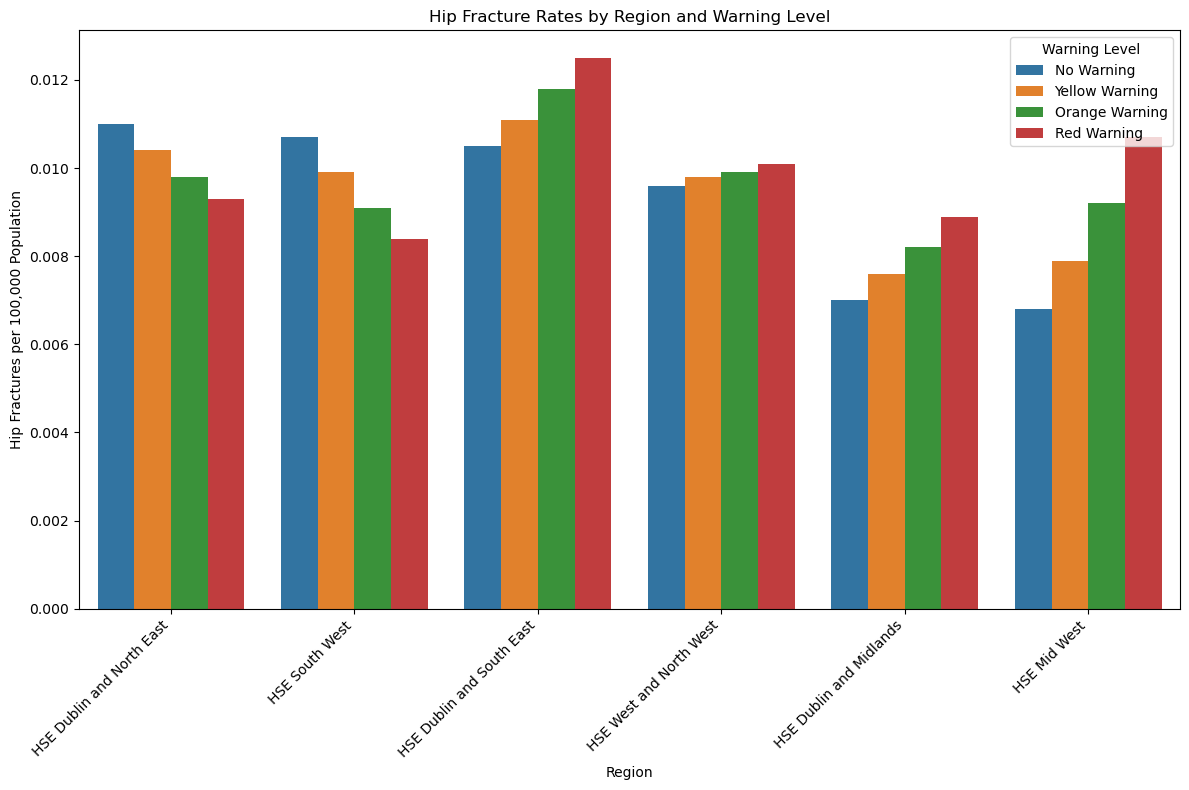

In [111]:
# Generate the combined rates table and plotting data
combined_rates, plot_data = generate_combined_rates_table(quasi_poisson_results, df_final, all_regions)

# Display the combined rates table
print("Combined Hip Fracture Rates by Region and Warning Level (per 100,000 population):")
print("==============================================================================")
print(combined_rates)

# Now you can use plot_data directly for visualization
# For example:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
g = sns.barplot(x='Region', y='Rate per 100,000', hue='Warning Level', data=plot_data)
plt.title('Hip Fracture Rates by Region and Warning Level')
plt.xlabel('Region')
plt.ylabel('Hip Fractures per 100,000 Population')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Warning Level')
plt.savefig('hip_fracture_rates_by_warning.png')
plt.show()

In [151]:
# After fitting the quasi-Poisson model
print("\nIncidence Rate Ratios (IRR) with 95% Confidence Intervals:")
params = quasi_poisson_results.params
conf = quasi_poisson_results.conf_int()

# Create a DataFrame for better formatting
irr_df = pd.DataFrame({
    'IRR': np.exp(params),
    'Lower CI': np.exp(conf[0]),
    'Upper CI': np.exp(conf[1]),
    'p-value': quasi_poisson_results.pvalues
})

print(irr_df)


Incidence Rate Ratios (IRR) with 95% Confidence Intervals:
                                                         IRR  Lower CI  \
Intercept                                           0.000005  0.000005   
region[T.HSE Dublin and North East]                 1.165555  1.119406   
region[T.HSE Dublin and South East]                 1.187357  1.139039   
region[T.HSE Mid West]                              1.076890  1.021635   
region[T.HSE South West]                            1.057393  1.010897   
region[T.HSE West and North West]                   1.096114  1.049046   
weather_event:warning_severity_numeric              1.027156  0.980515   
region[HSE Dublin and Midlands]:weather_event       0.949713  0.802045   
region[HSE Dublin and North East]:weather_event     1.098639  0.944148   
region[HSE Dublin and South East]:weather_event     0.987729  0.849197   
region[HSE Mid West]:weather_event                  0.918089  0.736831   
region[HSE South West]:weather_event                

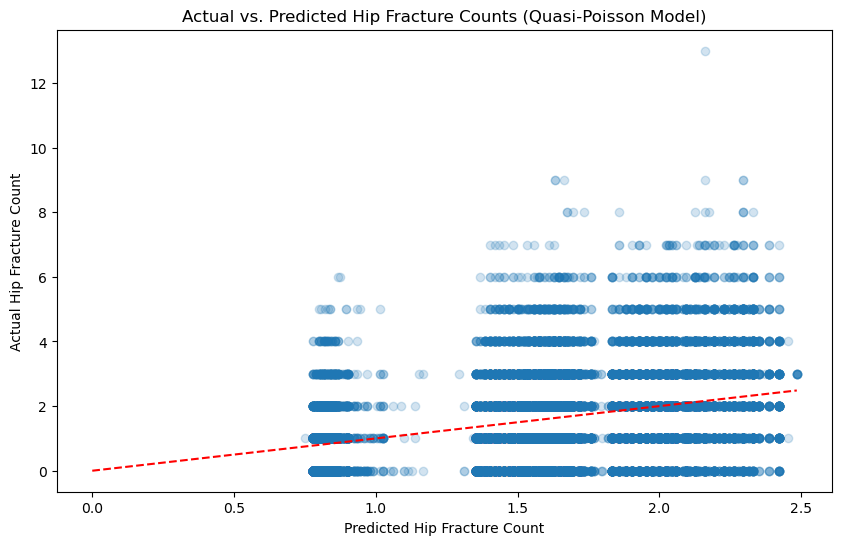

In [152]:
# Get predicted values from the model
df_final['predicted'] = quasi_poisson_results.predict(offset=np.log(df_final['population']))

# Plot actual vs. predicted counts
plt.figure(figsize=(10, 6))
plt.scatter(df_final['predicted'], df_final['hip_fracture_count'], alpha=0.2)
plt.plot([0, df_final['predicted'].max()], [0, df_final['predicted'].max()], 'r--')
plt.xlabel('Predicted Hip Fracture Count')
plt.ylabel('Actual Hip Fracture Count')
plt.title('Actual vs. Predicted Hip Fracture Counts (Quasi-Poisson Model)')
plt.show()

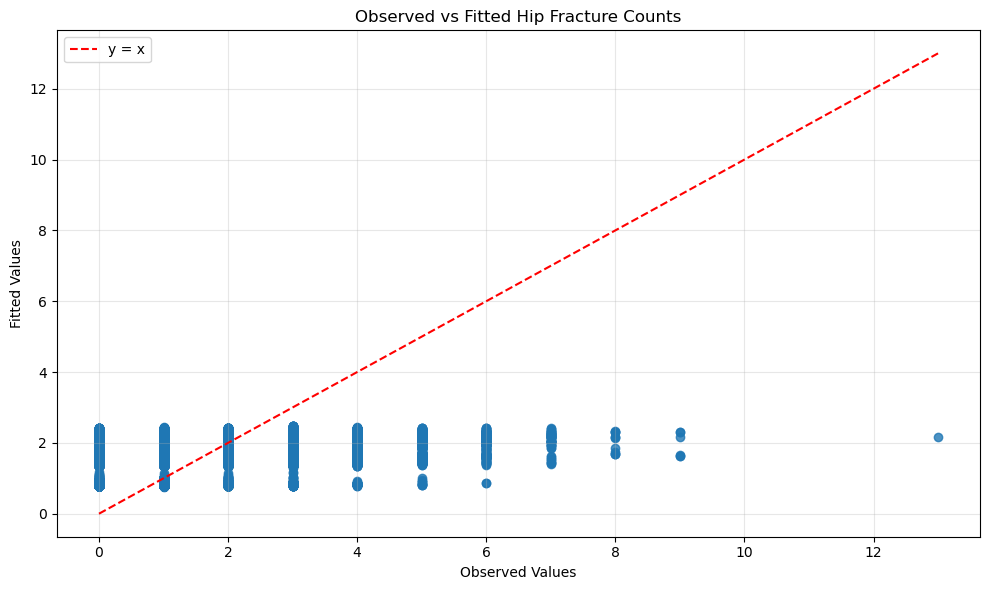

In [153]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 1. Observed vs Fitted Values Plot
# Create a new figure with matplotlib's pyplot
fig = plt.figure(figsize=(10, 6))
plt.scatter(df_final['hip_fracture_count'], quasi_poisson_results.fittedvalues, alpha=0.8)

# Get the maximum value for the diagonal line
max_val = max(df_final['hip_fracture_count'].max(), quasi_poisson_results.fittedvalues.max())
plt.plot([0, max_val], [0, max_val], '--', color='red', label='y = x')

# Add labels and formatting
plt.title('Observed vs Fitted Hip Fracture Counts')
plt.ylabel('Fitted Values')
plt.xlabel('Observed Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save and display
plt.savefig('observed_vs_fitted.png')
plt.show()



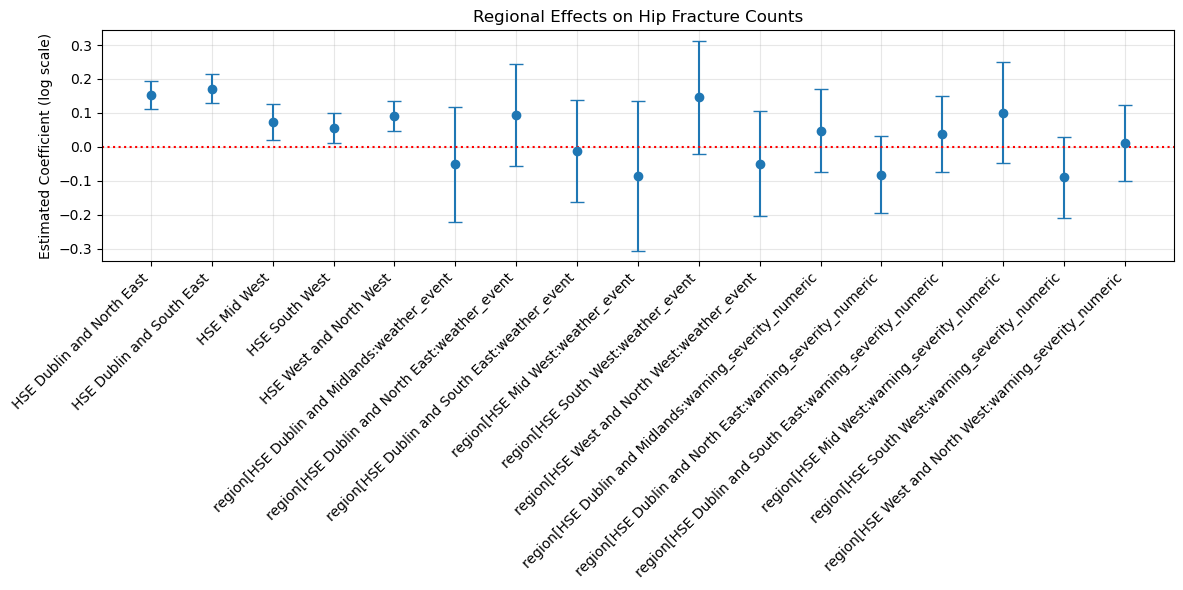

<Figure size 1500x600 with 0 Axes>

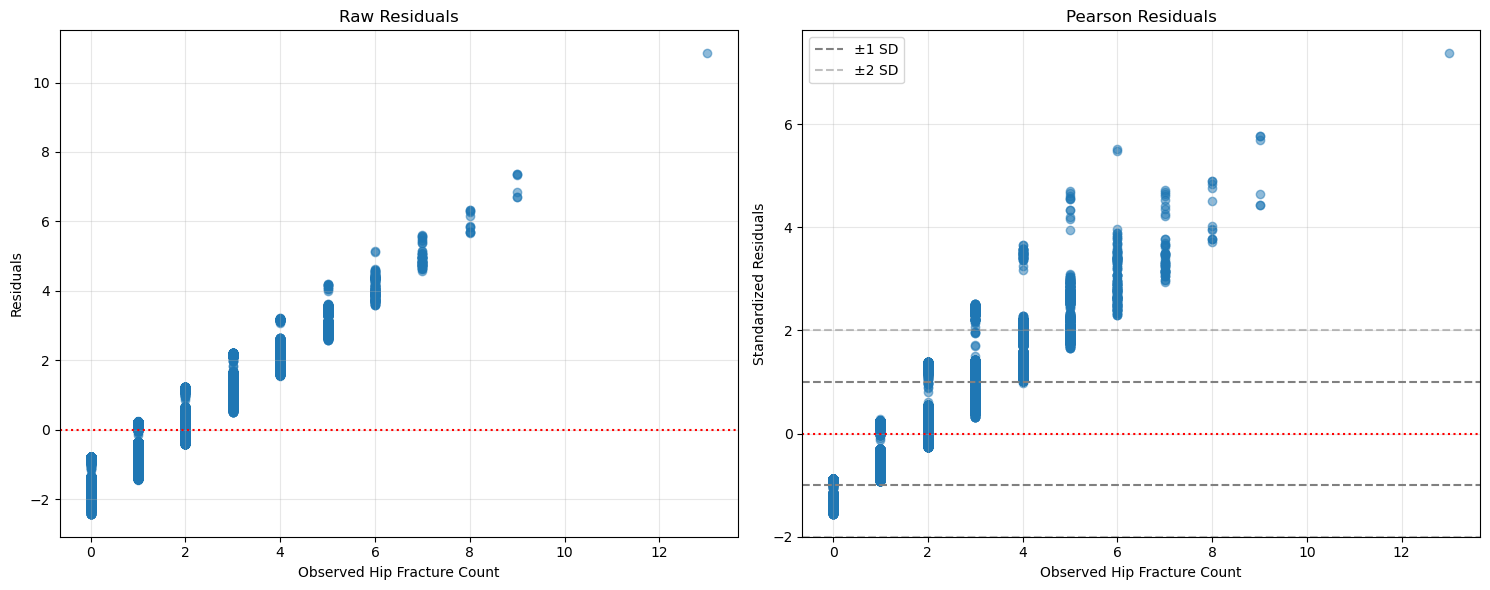

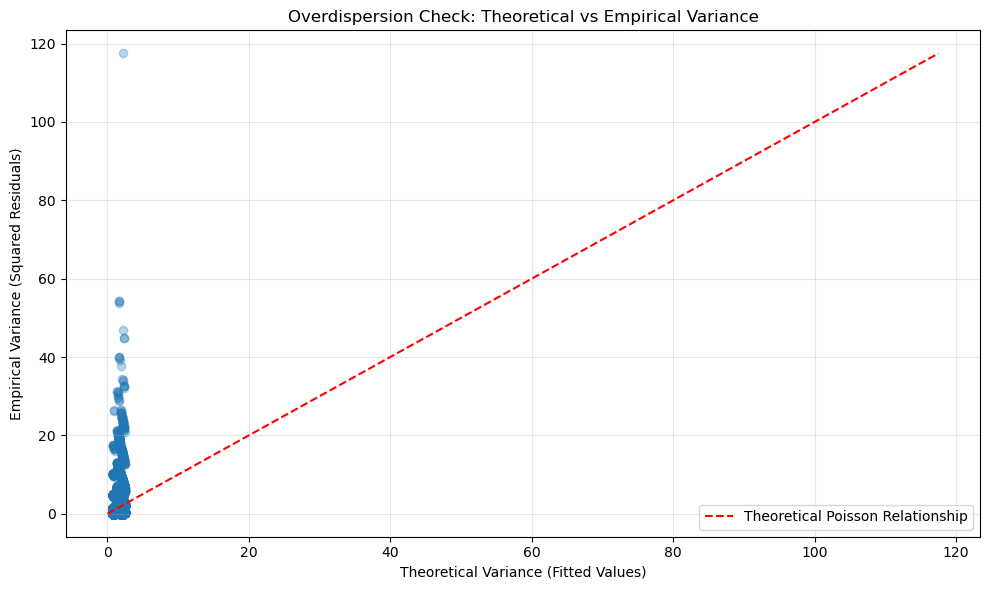

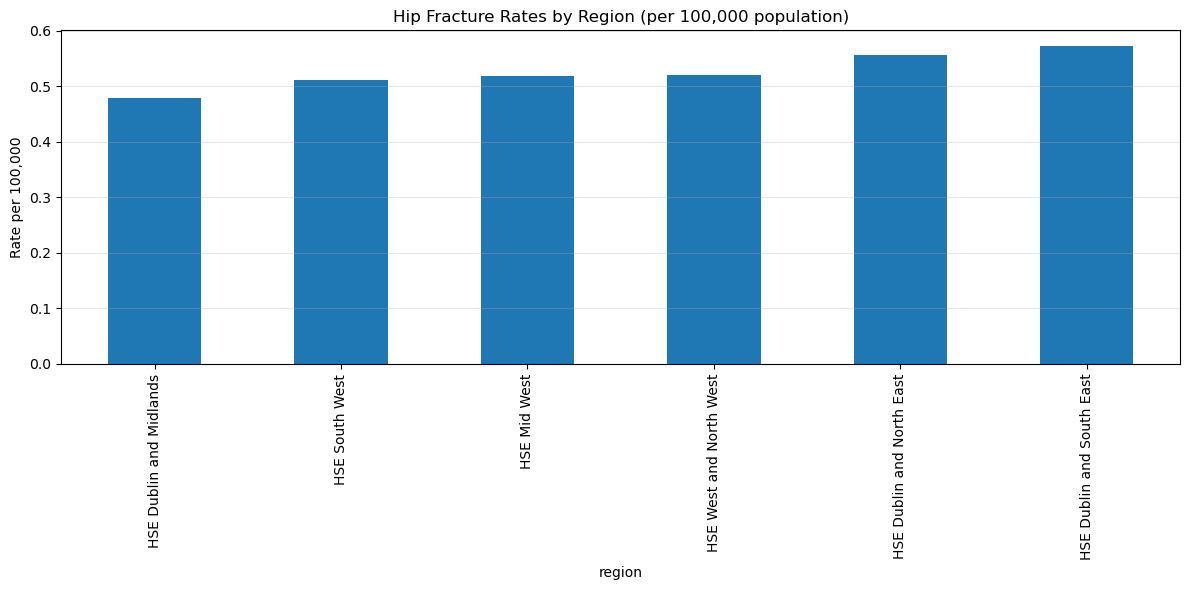

In [154]:
# 2. Regional Effects Plot
# Extract region coefficients and confidence intervals
region_params = quasi_poisson_results.params.filter(like='region')
region_conf = quasi_poisson_results.conf_int().loc[region_params.index]

# Create a DataFrame for easier plotting
region_df = pd.DataFrame({
    'Coefficient': region_params,
    'Lower': region_conf[0],
    'Upper': region_conf[1]
})

# Clean region names for plotting
region_df.index = region_df.index.str.replace('region[T.', '').str.replace(']', '')

plt.figure(figsize=(12, 6))
plt.errorbar(
    x=range(len(region_df)), 
    y=region_df['Coefficient'],
    yerr=[region_df['Coefficient'] - region_df['Lower'], 
          region_df['Upper'] - region_df['Coefficient']],
    fmt='o',
    capsize=5
)
plt.axhline(y=0, linestyle=':', color='red')
plt.xticks(range(len(region_df)), region_df.index, rotation=45, ha='right')
plt.title('Regional Effects on Hip Fracture Counts')
plt.ylabel('Estimated Coefficient (log scale)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('regional_effects.png')
plt.show()

# 3. Weather Type Effects Plot
# Extract weather type coefficients
weather_params = quasi_poisson_results.params.filter(like='C(weather_type)')
weather_conf = quasi_poisson_results.conf_int().loc[weather_params.index]

# Create a DataFrame for plotting
weather_df = pd.DataFrame({
    'Coefficient': weather_params,
    'Lower': weather_conf[0],
    'Upper': weather_conf[1]
})

# Clean weather type names
weather_df.index = weather_df.index.str.replace('C(weather_type)[T.', '').str.replace(']', '')


# 4. Residual Analysis Plots
plt.figure(figsize=(15, 6))
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Raw residuals
axes[0].scatter(df_final['hip_fracture_count'], quasi_poisson_results.resid_response, alpha=0.5)
axes[0].axhline(y=0, linestyle=':', color='red')
axes[0].set_ylabel('Residuals')
axes[0].set_xlabel('Observed Hip Fracture Count')
axes[0].set_title('Raw Residuals')
axes[0].grid(True, alpha=0.3)

# Pearson residuals (standardized)
axes[1].scatter(df_final['hip_fracture_count'], quasi_poisson_results.resid_pearson, alpha=0.5)
axes[1].axhline(y=0, linestyle=':', color='red')
axes[1].axhline(y=1, linestyle='--', color='gray', label='±1 SD')
axes[1].axhline(y=-1, linestyle='--', color='gray')
axes[1].axhline(y=2, linestyle='--', color='gray', alpha=0.5, label='±2 SD')
axes[1].axhline(y=-2, linestyle='--', color='gray', alpha=0.5)
axes[1].set_ylabel('Standardized Residuals')
axes[1].set_xlabel('Observed Hip Fracture Count')
axes[1].set_title('Pearson Residuals')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residual_analysis.png')
plt.show()



# 6. Overdispersion visualization
# Calculate the theoretical variance (should equal the mean for Poisson)
theoretical_variance = quasi_poisson_results.fittedvalues
# Calculate the empirical variance (based on squared residuals)
empirical_variance = quasi_poisson_results.resid_response ** 2

plt.figure(figsize=(10, 6))
plt.scatter(theoretical_variance, empirical_variance, alpha=0.3)
max_val = max(theoretical_variance.max(), empirical_variance.max())
plt.plot([0, max_val], [0, max_val], '--', color='red', label='Theoretical Poisson Relationship')
plt.title('Overdispersion Check: Theoretical vs Empirical Variance')
plt.xlabel('Theoretical Variance (Fitted Values)')
plt.ylabel('Empirical Variance (Squared Residuals)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('overdispersion_check.png')
plt.show()

# 7. Regional Hip Fracture Rates (Adjusted for Population)
# Calculate adjusted rates by region (using model predictions)
region_rates = df_final.groupby('region')['hip_fracture_count'].sum() / df_final.groupby('region')['population'].sum() * 100000  # per 100,000 people

plt.figure(figsize=(12, 6))
region_rates.sort_values().plot(kind='bar')
plt.title('Hip Fracture Rates by Region (per 100,000 population)')
plt.ylabel('Rate per 100,000')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('regional_rates.png')
plt.show()

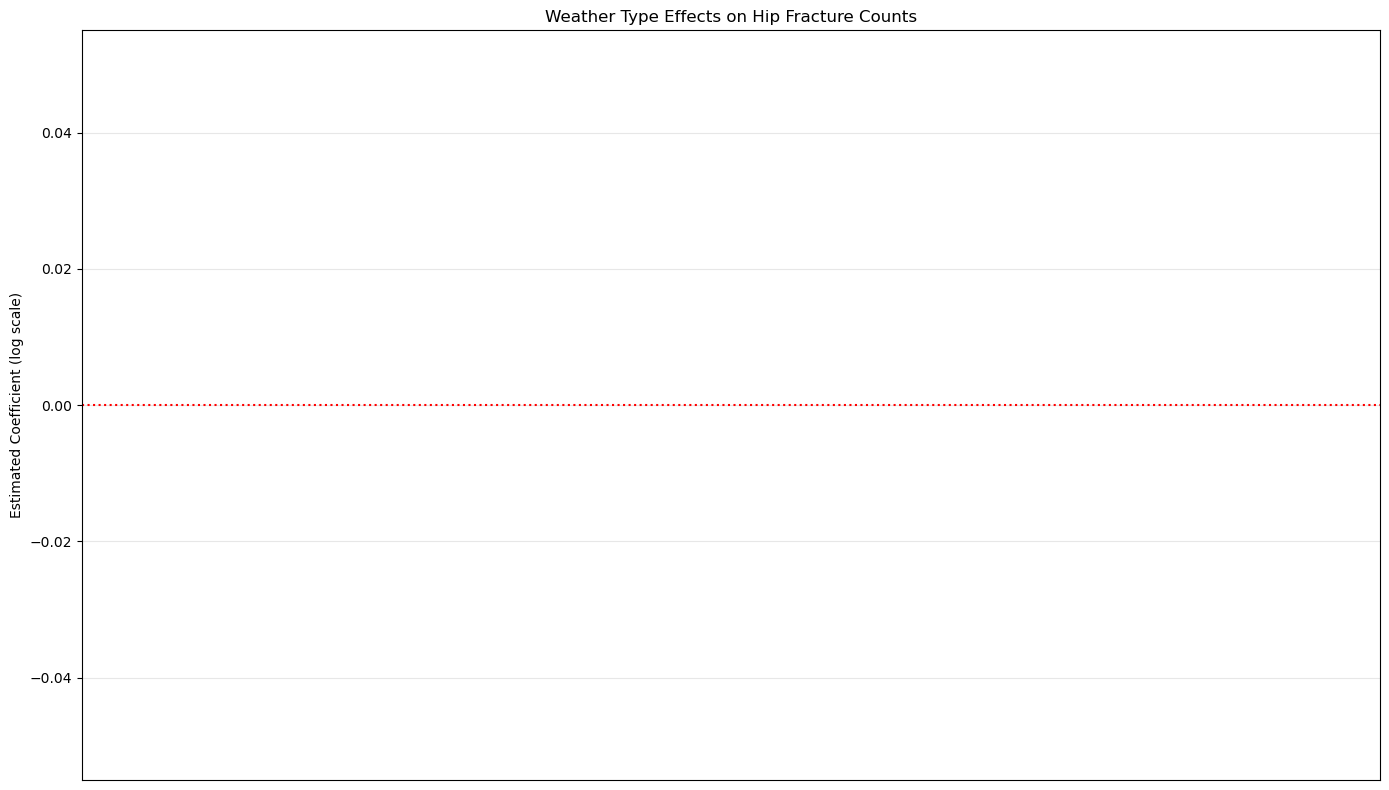

In [155]:
# Sort by coefficient value for better visualization
weather_df = weather_df.sort_values('Coefficient')

plt.figure(figsize=(14, 8))
plt.errorbar(
    x=range(len(weather_df)),
    y=weather_df['Coefficient'],
    yerr=[weather_df['Coefficient'] - weather_df['Lower'],
          weather_df['Upper'] - weather_df['Coefficient']],
    fmt='o',
    capsize=5
)
plt.axhline(y=0, linestyle=':', color='red')
plt.xticks(range(len(weather_df)), weather_df.index, rotation=90)
plt.title('Weather Type Effects on Hip Fracture Counts')
plt.ylabel('Estimated Coefficient (log scale)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('weather_effects.png')
plt.show()

In [156]:
import statsmodels.formula.api as smf

# Define the model formula
formula = "hip_fracture_count ~ weather_event:warning_severity_numeric + region"

# Fit the Negative Binomial model
nb_model = smf.glm(formula=formula, data=df_final,
                   family=sm.families.NegativeBinomial(),offset=df_final['log_population']).fit()

# Print the summary of the model
print(nb_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:     hip_fracture_count   No. Observations:                23124
Model:                            GLM   Df Residuals:                    23117
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -39571.
Date:                Wed, 26 Feb 2025   Deviance:                       13321.
Time:                        10:25:44   Pearson chi2:                 9.56e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.002386
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

/home/paulharford/anaconda3/envs/msc/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
